In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from sklearn.model_selection import KFold
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import os, random
import pandas as pd
from torchvision.io import read_image

EDA (Exploratory Data Analysis) and Preprocessing

In [2]:
data_dir = "../../../Datasets/Land-Use Scene Classification/images"

In [3]:
def count_target_classes(root_dir):
    '''return count of number of images per class'''
    target_classes = {}
    for folder in sorted(os.listdir(root_dir)):
        data_path_for_image_folder = root_dir+ '/'+str(folder) + '/'
        target_classes[str(folder)] = len([image_filename for image_filename in sorted(os.listdir(data_path_for_image_folder))])
    return target_classes

In [4]:
dict_class_count = count_target_classes(data_dir)

print("Total number of images for the datasets are :",sum(dict_class_count.values()))

Total number of images for the datasets are : 10500


In [5]:
def plot_hist(dict_target_count):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(8,6))
    plt.bar(dict_target_count.keys(), dict_target_count.values(), 
            color= ['aqua', 'gold', 'green', 'blue'], edgecolor='k')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Number of images per class")
    plt.show()
    plt.close()

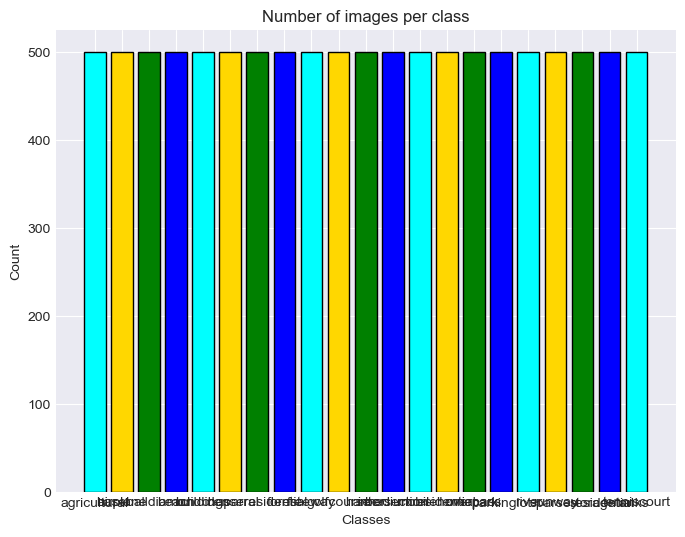

In [6]:
plot_hist(dict_class_count)

In [7]:
def print_images(root_dir):
    '''return count of number of images per class'''
    plt.style.use('seaborn-white')
    images_plt=[]
    classes=[]
    pic_num = len(os.listdir(root_dir))
    f, axarr = plt.subplots(1,pic_num, figsize=(15,15))
    i = 0
    for folder in sorted(os.listdir(root_dir)):
      image_folder = root_dir+ '/'+str(folder) + '/'
      classes.append(str(folder))
      images_plt.append(image.imread(random.choice([image_folder+image_filename for image_filename in sorted(os.listdir(image_folder))])))
      axarr[i].imshow(images_plt[i])
      axarr[i].set_title(classes[i])
      i += 1
    plt.show

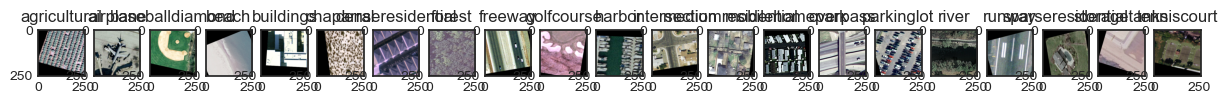

In [8]:

print_images(data_dir)

In [9]:
def dataset_loader(path, test_split, input_size, batch_size, shuffle_test=False):
    
    transform_dict = {'src':  transforms.Compose([transforms.Resize(input_size), 
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomAdjustSharpness(0.2),
                                                transforms.RandomAutocontrast(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])}

    data = datasets.ImageFolder(root=path, transform=transform_dict["src"])

    test_size = int(len(data) * test_split)
    train_size = len(data)- test_size

    train_dataset, test_dataset = td.random_split(data, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)

    return train_loader,test_loader

In [10]:
train_loader, test_loader = dataset_loader(data_dir, test_split=0.2, input_size=[64,64], batch_size=32)

In [11]:
def train(num_epochs, model, train_loader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    model.to(device)

    total_steps = len(train_loader)
    e_lossLst = []
    e_accLst = []

    for epoch in range(num_epochs):
        b_lossLst = []
        b_accLst = []
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            b_lossLst.append(loss)
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total = labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            b_accLst.append((correct / total) * 100)
        meanAcc = sum(b_accLst) / len(b_accLst)
        meanLoss = sum(b_lossLst) / len(b_lossLst)
        e_lossLst.append(meanAcc)
        e_accLst.append(meanLoss)
        print('Epoch [{}/{}], Accuracy: {:.2f}%, Mean Loss: {:.2f}'.format(epoch + 1, num_epochs, meanAcc, meanLoss))
    return e_accLst, e_lossLst, model

In [12]:
def plot_function(num_epochs, lst, yLabel):
    epochs = [i for i in range(num_epochs)]
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(yLabel)
    plt.title(yLabel+" plot")
    plt.plot(epochs,lst)

In [13]:
model = models.vgg16(weights=None)  # By default, no pre-trained weights are used.
model.classifier._modules['6'] = nn.Linear(4096, len(dict_class_count)) # change output parameters to match number of classes
# define the loss function
criterion = nn.CrossEntropyLoss()
#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),  lr=0.00001)
num_epochs = 10
accLst, lossLst, trained_model = train(num_epochs, model, train_loader, criterion, optimizer)

Device: cuda:0
Epoch [1/10], Accuracy: 7.90%, Mean Loss: 2.96
Epoch [2/10], Accuracy: 13.15%, Mean Loss: 2.74
Epoch [3/10], Accuracy: 20.79%, Mean Loss: 2.46
Epoch [4/10], Accuracy: 25.00%, Mean Loss: 2.30
Epoch [5/10], Accuracy: 28.32%, Mean Loss: 2.17
Epoch [6/10], Accuracy: 31.95%, Mean Loss: 2.06
Epoch [7/10], Accuracy: 36.53%, Mean Loss: 1.94
Epoch [8/10], Accuracy: 38.45%, Mean Loss: 1.86
Epoch [9/10], Accuracy: 41.12%, Mean Loss: 1.77
Epoch [10/10], Accuracy: 43.03%, Mean Loss: 1.73


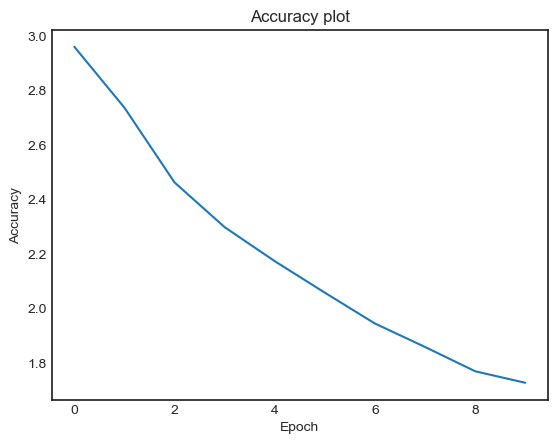

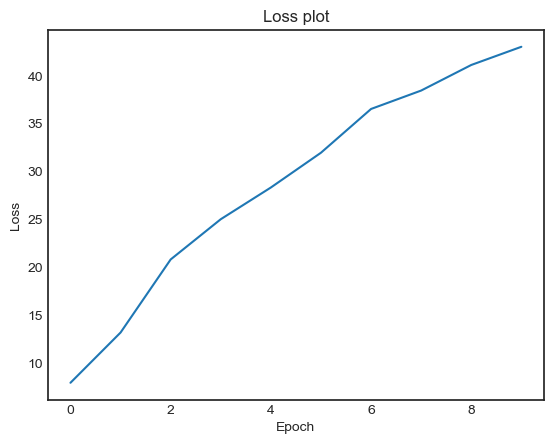

In [14]:
pltAcc = []
for epoch in accLst:
    pltAcc.append(epoch.cpu().item())
plot_function(num_epochs, pltAcc, "Accuracy")
plot_function(num_epochs, lossLst, "Loss")